# Essai pre-traitement du dataset

## Librairies importation

In [15]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image
from nipype.interfaces.fsl import BET, FLIRT, MCFLIRT
from nipype.algorithms.misc import Gunzip
from nipype import Node, Workflow

# Définir les chemins
dataset_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/ds003768-download/'
fmri_path_sub_01_sess_01 = os.path.join(dataset_path, 'sub-01/func/sub-01_task-rest_run-1_bold.nii.gz')
t1_img_path = os.path.join(dataset_path, 'sub-01/anat/sub-01_T1w.nii.gz')


## Function definition

In [17]:
# Fonction pour redresser l'image avec FSL FLIRT
def fsl_flirt_resample(input_img_path, ref_img_path, output_img_path):
    flirt = FLIRT(in_file=input_img_path, reference=ref_img_path, out_file=output_img_path)
    flirt.run()

# Fonction pour visualiser une image 3D
def visualize_3d_img(img, title):
    plotting.plot_anat(img, title=title)
    plt.show()

# Fonction pour visualiser une image 4D (premier volume)
def visualize_4d_img(img, title):
    first_volume = image.index_img(img, 0)
    plotting.plot_epi(first_volume, title=title)
    plt.show()


## 1. Node definition and decompression of fMRI data

240604-16:04:56,469 nipype.workflow INFO:
	 [Node] Setting-up "gunzip_func" in "/tmp/tmptzqpdx75/gunzip_func".
240604-16:04:56,474 nipype.workflow INFO:
	 [Node] Executing "gunzip_func" <nipype.algorithms.misc.Gunzip>
240604-16:04:57,165 nipype.workflow INFO:
	 [Node] Finished "gunzip_func", elapsed time 0.689269s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


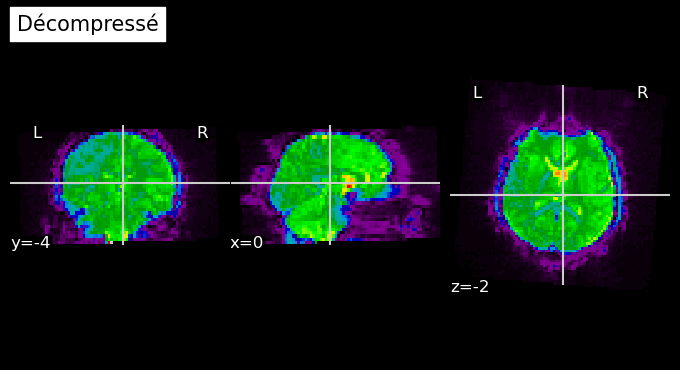

In [18]:
# Définir le noeud pour la décompression des fichiers gzip
gunzip_node = Node(Gunzip(), name='gunzip_func')
gunzip_node.inputs.in_file = fmri_path_sub_01_sess_01

# Exécuter Gunzip
gunzip_res = gunzip_node.run()

# Visualiser l'image décompressée
decompressed_img = nib.load(gunzip_res.outputs.out_file)
visualize_4d_img(decompressed_img, "Décompressé")

## 2. Mouvment correction

240604-16:05:44,737 nipype.workflow INFO:
	 [Node] Setting-up "mcflirt" in "/tmp/tmpkbbwl3up/mcflirt".
240604-16:05:44,740 nipype.workflow INFO:
	 [Node] Executing "mcflirt" <nipype.interfaces.fsl.preprocess.MCFLIRT>
240604-16:06:23,631 nipype.workflow INFO:
	 [Node] Finished "mcflirt", elapsed time 38.890415s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


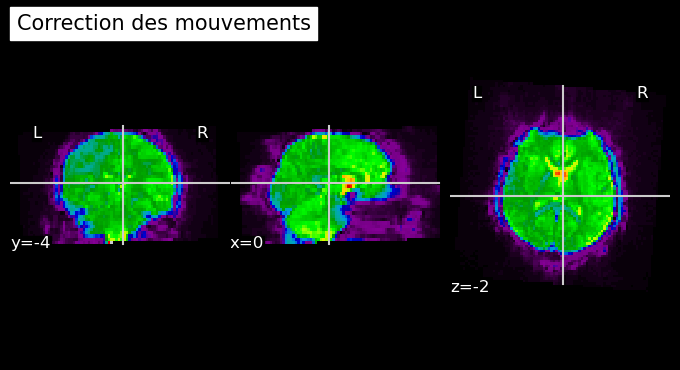

In [19]:
# Définir le noeud pour la correction des mouvements
mcflirt_node = Node(MCFLIRT(), name='mcflirt')
mcflirt_node.inputs.out_file = 'mcflirt_corrected.nii.gz'
mcflirt_node.inputs.in_file = gunzip_res.outputs.out_file

# Exécuter MCFLIRT pour la correction des mouvements
mcflirt_res = mcflirt_node.run()

# Visualiser l'image corrigée des mouvements
mcflirt_img = nib.load(mcflirt_res.outputs.out_file)
visualize_4d_img(mcflirt_img, "Correction des mouvements")

## 3. Brain extraction with BET

240604-16:07:13,91 nipype.workflow INFO:
	 [Node] Setting-up "extract" in "/tmp/tmpjt9w0ns0/extract".
240604-16:07:13,94 nipype.workflow INFO:
	 [Node] Executing "extract" <nipype.interfaces.fsl.preprocess.BET>
240604-16:07:13,948 nipype.workflow INFO:
	 [Node] Finished "extract", elapsed time 0.852246s.
240604-16:07:13,959 nipype.workflow INFO:
	 [Node] Setting-up "extract" in "/tmp/tmpjt9w0ns0/extract".
240604-16:07:13,960 nipype.workflow INFO:
	 [Node] Cached "extract" - collecting precomputed outputs
240604-16:07:13,960 nipype.workflow INFO:
	 [Node] "extract" found cached.
240604-16:07:13,972 nipype.workflow INFO:
	 [Node] Setting-up "extract" in "/tmp/tmpjt9w0ns0/extract".
240604-16:07:13,974 nipype.workflow INFO:
	 [Node] Cached "extract" - collecting precomputed outputs
240604-16:07:13,974 nipype.workflow INFO:
	 [Node] "extract" found cached.
240604-16:07:13,985 nipype.workflow INFO:
	 [Node] Setting-up "extract" in "/tmp/tmpjt9w0ns0/extract".
240604-16:07:13,986 nipype.workfl

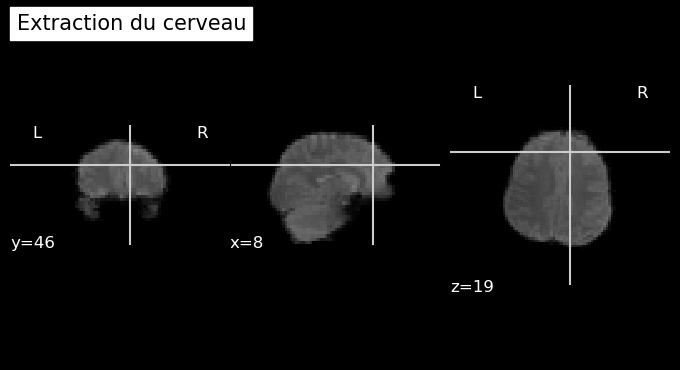

In [20]:
# Définir le noeud pour l'extraction avec BET
bet_node = Node(BET(), name='extract')
bet_node.inputs.out_file = 'output_brain.nii.gz'

# Extraire le premier volume de l'image corrigée des mouvements pour BET
first_vol_path = os.path.join('/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory', 'mcflirt_first_vol.nii.gz')
first_volume = image.index_img(mcflirt_img, 0)
nib.save(first_volume, first_vol_path)

# Essayer plusieurs valeurs de fraction pour BET
best_frac = 0.3  # Initialiser avec une valeur par défaut
best_extracted_img = None

for frac in [0.3, 0.4, 0.5, 0.6, 0.7]:
    bet_node.inputs.frac = frac
    bet_node.inputs.in_file = first_vol_path
    bet_res = bet_node.run()
    
    # Vérifier si l'extraction est réussie
    extracted_img = nib.load(bet_res.outputs.out_file)
    extracted_data = extracted_img.get_fdata()
    
    # Critère pour sélectionner la meilleure extraction (à définir selon les besoins)
    # Ici, nous choisissons la fraction avec la plus grande moyenne de l'image extraite
    mean_intensity = np.mean(extracted_data)
    if best_extracted_img is None or mean_intensity > np.mean(best_extracted_img.get_fdata()):
        best_extracted_img = extracted_img
        best_frac = frac

print(f"Meilleure fraction pour BET: {best_frac}")
visualize_3d_img(best_extracted_img, "Extraction du cerveau")


## 4. Verification de l'alignement avec le T1

Vérification de l'alignement : 


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


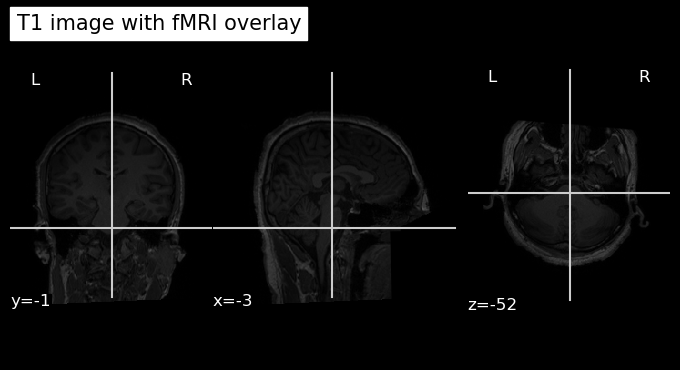

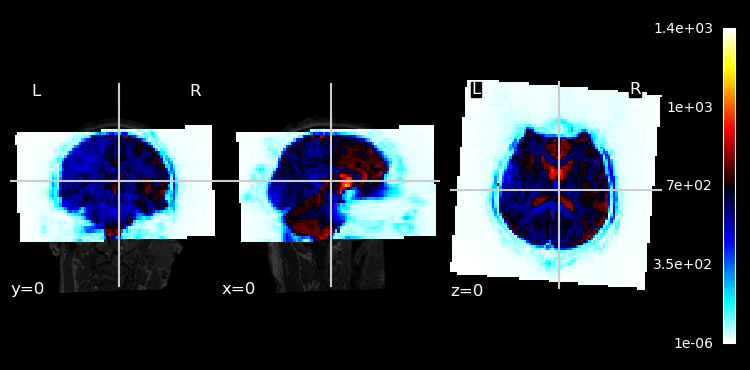

In [21]:
# Charger l'image T1
T1_image = nib.load(t1_img_path)

# Vérifier l'alignement en utilisant le premier volume de l'image fMRI corrigée
print("Vérification de l'alignement : ")
display = plotting.plot_anat(T1_image, title="T1 image with fMRI overlay")
first_volume_mcflirt = image.index_img(mcflirt_img, 0)
plotting.plot_stat_map(first_volume_mcflirt, bg_img=T1_image, display_mode='ortho', cut_coords=(0, 0, 0), draw_cross=True)
plt.show()


## 5. Assemblage du workflow

In [22]:
# Créer le workflow
preproc_workflow = Workflow(name='work_preproc', base_dir='/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory')

# Ajouter les noeuds au workflow
preproc_workflow.add_nodes([gunzip_node, bet_node, mcflirt_node])

# Connecter les noeuds
preproc_workflow.connect([
    (gunzip_node, mcflirt_node, [('out_file', 'in_file')]),
    (mcflirt_node, bet_node, [('out_file', 'in_file')])
])


    On peut maintenant utiliser le workflow au complet en appelant preproc_workflow si j'ai bien compris

## Tout d'un coup : 

240604-17:06:42,904 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.gunzip_func" in "/tmp/tmphozuz3cv/work_preproc/gunzip_func".
240604-17:06:42,907 nipype.workflow INFO:
	 [Node] Executing "gunzip_func" <nipype.algorithms.misc.Gunzip>
240604-17:06:43,554 nipype.workflow INFO:
	 [Node] Finished "gunzip_func", elapsed time 0.644947s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


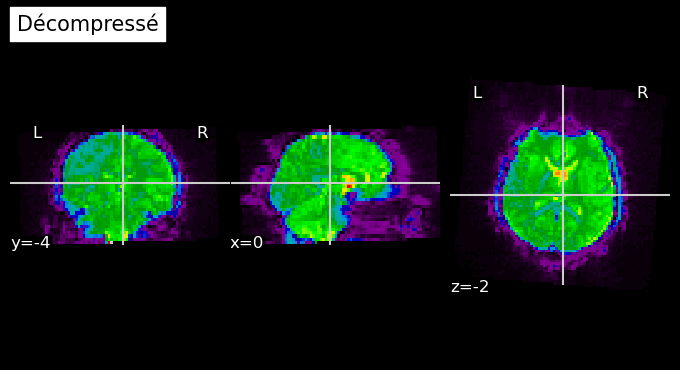

240604-17:06:44,157 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.mcflirt" in "/tmp/tmphev6fs4e/work_preproc/mcflirt".
240604-17:06:44,159 nipype.workflow INFO:
	 [Node] Executing "mcflirt" <nipype.interfaces.fsl.preprocess.MCFLIRT>
240604-17:07:23,998 nipype.workflow INFO:
	 [Node] Finished "mcflirt", elapsed time 39.837054s.


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


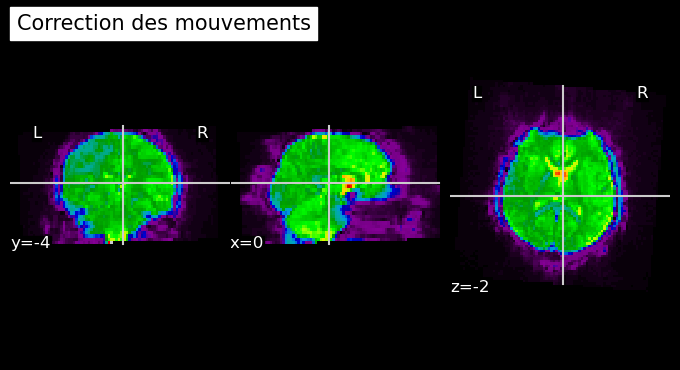

240604-17:07:25,170 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.extract" in "/tmp/tmpd4dpldqk/work_preproc/extract".
240604-17:07:25,190 nipype.workflow INFO:
	 [Node] Executing "extract" <nipype.interfaces.fsl.preprocess.BET>
240604-17:07:26,60 nipype.workflow INFO:
	 [Node] Finished "extract", elapsed time 0.868252s.
240604-17:07:26,69 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.extract" in "/tmp/tmpd4dpldqk/work_preproc/extract".
240604-17:07:26,71 nipype.workflow INFO:
	 [Node] Cached "work_preproc.extract" - collecting precomputed outputs
240604-17:07:26,71 nipype.workflow INFO:
	 [Node] "work_preproc.extract" found cached.
240604-17:07:26,82 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.extract" in "/tmp/tmpd4dpldqk/work_preproc/extract".
240604-17:07:26,83 nipype.workflow INFO:
	 [Node] Cached "work_preproc.extract" - collecting precomputed outputs
240604-17:07:26,84 nipype.workflow INFO:
	 [Node] "work_preproc.extract" found cached.
240604-17:0

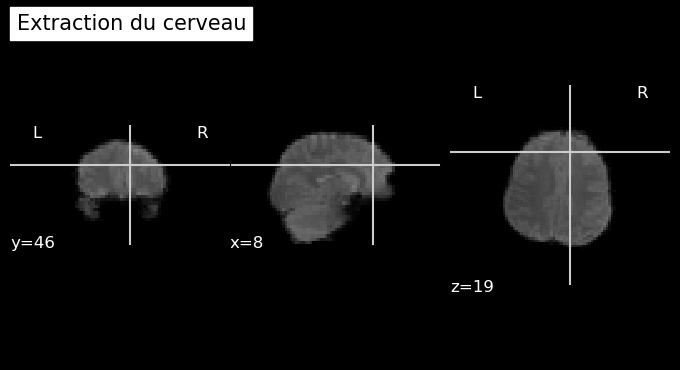

Vérification de l'alignement : 


/home/rduchadeau/miniconda3/lib/python3.12/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(


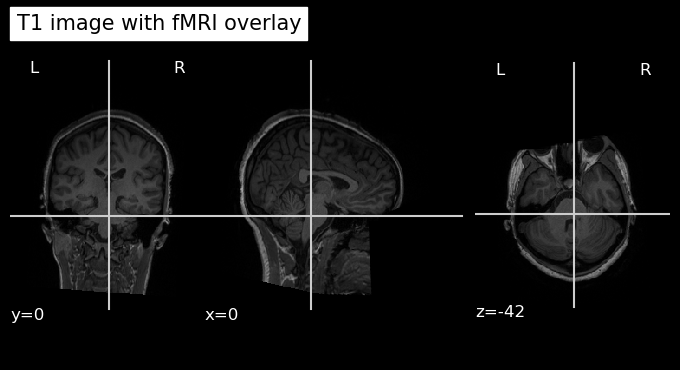

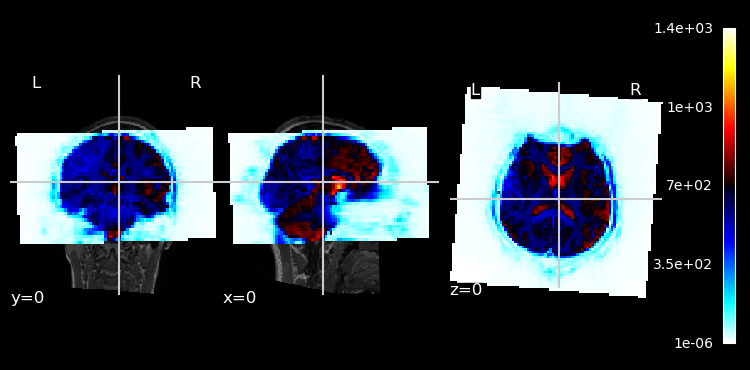

In [24]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image
from nipype.interfaces.fsl import BET, FLIRT, MCFLIRT
from nipype.algorithms.misc import Gunzip
from nipype import Node, Workflow

# Définir les chemins
dataset_path = '/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/ds003768-download/'
fmri_path_sub_02_sess_02 = os.path.join(dataset_path, 'sub-02/func/sub-02_task-rest_run-2_bold.nii.gz')
t1_img_path = os.path.join(dataset_path, 'sub-02/anat/sub-02_T1w.nii.gz')

# Fonction pour redresser l'image avec FSL FLIRT
def fsl_flirt_resample(input_img_path, ref_img_path, output_img_path):
    flirt = FLIRT(in_file=input_img_path, reference=ref_img_path, out_file=output_img_path)
    flirt.run()

# Définir le noeud pour la décompression des fichiers gzip
gunzip_node = Node(Gunzip(), name='gunzip_func')
gunzip_node.inputs.in_file = fmri_path_sub_01_sess_01

# Définir le noeud pour l'extraction avec BET
bet_node = Node(BET(), name='extract')
bet_node.inputs.out_file = 'output_brain.nii.gz'

# Définir le noeud pour la correction des mouvements
mcflirt_node = Node(MCFLIRT(), name='mcflirt')
mcflirt_node.inputs.out_file = 'mcflirt_corrected.nii.gz'

# Créer le workflow
preproc_workflow = Workflow(name='work_preproc', base_dir='/home/rduchadeau/Desktop/Brainhack_school/duchadeau_project/working_directory')

# Ajouter les noeuds au workflow
preproc_workflow.add_nodes([gunzip_node, bet_node, mcflirt_node])

# Connecter les noeuds
preproc_workflow.connect([
    (gunzip_node, mcflirt_node, [('out_file', 'in_file')]),
    (mcflirt_node, bet_node, [('out_file', 'in_file')])
])

# Fonction pour visualiser une image 3D
def visualize_3d_img(img, title):
    plotting.plot_anat(img, title=title)
    plt.show()

# Fonction pour visualiser une image 4D (premier volume)
def visualize_4d_img(img, title):
    first_volume = image.index_img(img, 0)
    plotting.plot_epi(first_volume, title=title)
    plt.show()

########## Main ###########
# Exécuter le workflow étape par étape pour insérer des visualisations
# Exécuter Gunzip
gunzip_res = gunzip_node.run()

# Visualiser l'image décompressée
decompressed_img = nib.load(gunzip_res.outputs.out_file)
visualize_4d_img(decompressed_img, "Décompressé")

# Exécuter MCFLIRT pour la correction des mouvements
mcflirt_node.inputs.in_file = gunzip_res.outputs.out_file
mcflirt_res = mcflirt_node.run()

# Visualiser l'image corrigée des mouvements
mcflirt_img = nib.load(mcflirt_res.outputs.out_file)
visualize_4d_img(mcflirt_img, "Correction des mouvements")

# Extraire le premier volume de l'image corrigée des mouvements pour BET
first_vol_path = os.path.join(preproc_workflow.base_dir, 'mcflirt_first_vol.nii.gz')
first_volume = image.index_img(mcflirt_img, 0)
nib.save(first_volume, first_vol_path)

# Essayer plusieurs valeurs de fraction pour BET
best_frac = 0.3  # Initialiser avec une valeur par défaut
best_extracted_img = None

for frac in [0.3, 0.4, 0.5, 0.6, 0.7]:
    bet_node.inputs.frac = frac
    bet_node.inputs.in_file = first_vol_path
    bet_res = bet_node.run()
    
    # Vérifier si l'extraction est réussie
    extracted_img = nib.load(bet_res.outputs.out_file)
    extracted_data = extracted_img.get_fdata()
    
    # Critère pour sélectionner la meilleure extraction (à définir selon les besoins)
    # Ici, nous choisissons la fraction avec la plus grande moyenne de l'image extraite
    mean_intensity = np.mean(extracted_data)
    if best_extracted_img is None or mean_intensity > np.mean(best_extracted_img.get_fdata()):
        best_extracted_img = extracted_img
        best_frac = frac

print(f"Meilleure fraction pour BET: {best_frac}")
visualize_3d_img(best_extracted_img, "Extraction du cerveau")

# Charger l'image T1
T1_image = nib.load(t1_img_path)

# Vérifier l'alignement en utilisant le premier volume de l'image fMRI corrigée
print("Vérification de l'alignement : ")
display = plotting.plot_anat(T1_image, title="T1 image with fMRI overlay")
first_volume_mcflirt = image.index_img(mcflirt_img, 0)
plotting.plot_stat_map(first_volume_mcflirt, bg_img=T1_image, display_mode='ortho', cut_coords=(0, 0, 0), draw_cross=True)
plt.show()
